# Style Transfer  using Deep Learning
(Udacity Deep Learning using PyTorch)

In [1]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
def load_image(file, max_size = 400, shape = None):
    
    '''Loading and pre-processing the image'''
    
    image = Image.open(file).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
        
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                            (0.229, 0.224, 0.225))
    ])
    
    
    image = transform(image)[:3, :, :].unsqueeze(0)
    
    return image

In [8]:
content = load_image("/content/drive/MyDrive/images/fed.jpg").to(device)
style = load_image("/content/drive/MyDrive/images/delaunay.jpg").to(device)

In [9]:
# Convert image to numpy and make it ready for diaplying

def convert_back(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

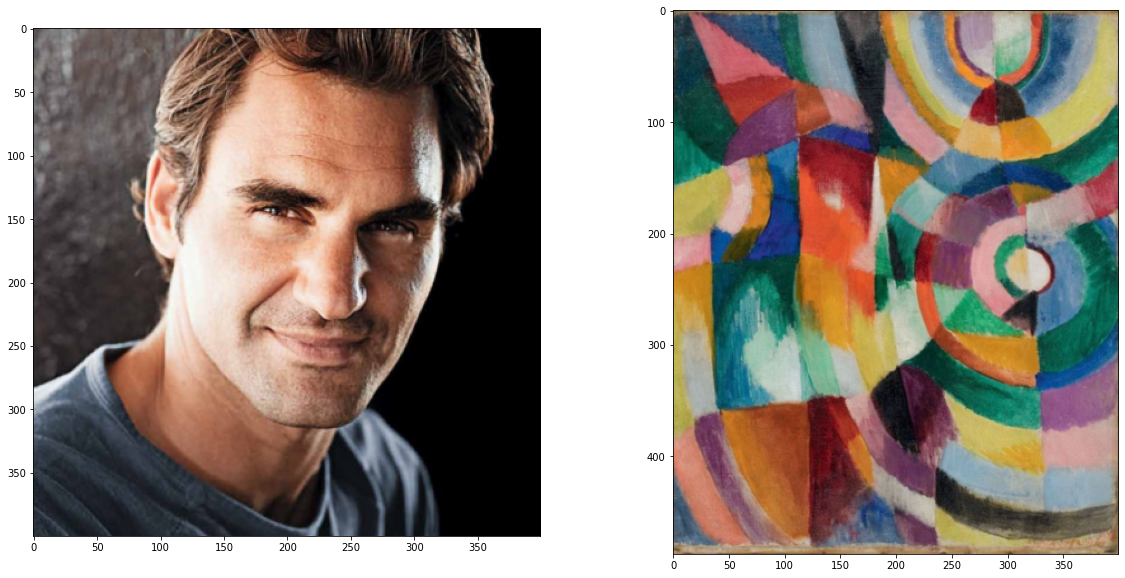

In [10]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(convert_back(content))
ax2.imshow(convert_back(style))

In [11]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [12]:
print(vgg._modules['0'])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## Getting the Features from the Pretrained Models and Mapping the Layers

In [13]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

## Calculating Gram Matrix

In [14]:
def gram_matrix(tensor):
    
    b, d, h, w = tensor.size()
    
    tensor = tensor.view(b*d, h*w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [15]:
content_image = get_features(content, vgg)
style_image = get_features(style, vgg)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [16]:
#gram matrix for each layer
style_grams = {layer: gram_matrix(style_image[layer]) for layer in style_image}
target = content.clone().requires_grad_(True).to(device)

In [21]:
# Giving weights to every style layer while adding the losses

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1

style_weight = 1e6

### Calculating Style Loss, Content Loss, and Total Loss

Total loss:  2428068.25


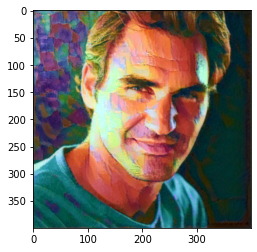

Total loss:  845558.9375


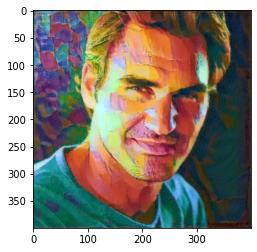

Total loss:  515965.65625


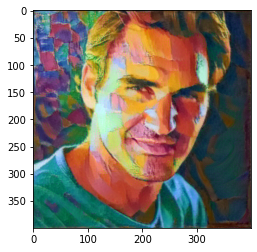

Total loss:  380910.21875


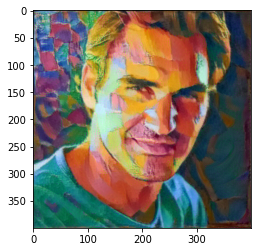

Total loss:  303830.71875


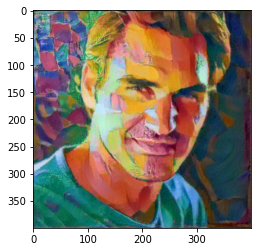

Total loss:  253355.578125


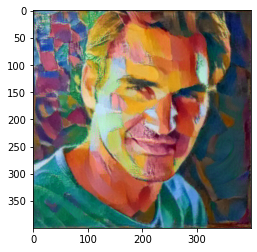

Total loss:  217951.203125


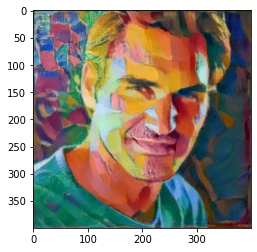

Total loss:  192464.484375


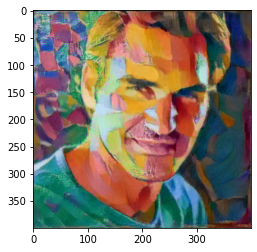

Total loss:  173609.375


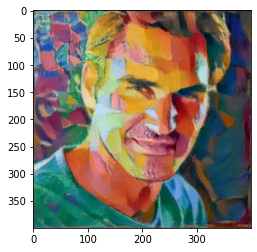

Total loss:  159628.0625


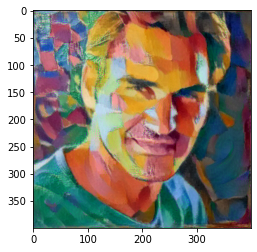

Total loss:  148907.765625


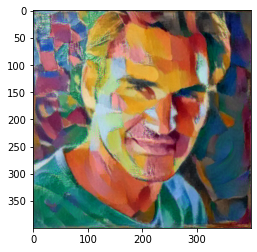

Total loss:  140744.53125


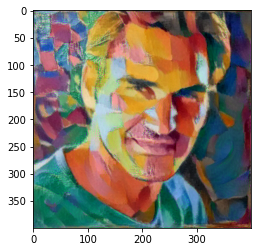

Total loss:  134049.546875


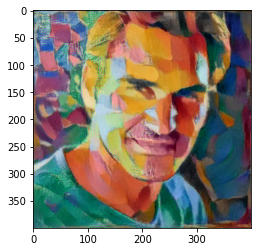

Total loss:  128458.59375


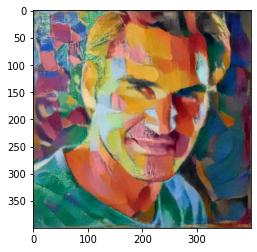

Total loss:  123837.9375


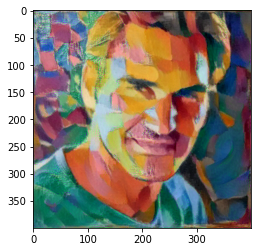

Total loss:  119906.8671875


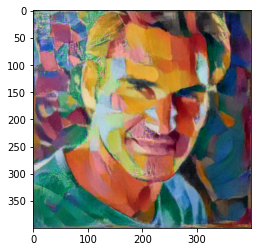

In [22]:
optimizer = torch.optim.Adam([target], lr = 0.003)
iters = 8000
show_every = 500
for i in range(1, iters + 1):
    
    target_features = get_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_image['conv4_2'])**2)
    
    style_loss = 0
    
    for layer in style_weights:
        
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        
        _, d, h, w = target_feature.shape
        
        style_gram = style_grams[layer]
        style_layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += style_layer_loss / (d * h * w)
        
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(convert_back(target))
        plt.show()
    